### 2D Poisson Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:

$$
\begin{cases}
    \Delta u + f = 0, (x,y) \in \Omega\\
    u = g, (x,y) \in \partial \Omega
\end{cases}
$$

with:
$$
    f(x,y) = 2\lambda^2 cos(\lambda x) sin(\lambda y)\\
    \lambda = 2 \pi q
$$

### Ground Truth
$$
g(x,y) = cos(\lambda x) sin(\lambda y)
$$

In [1]:
import numpy as np
import torch
import scipy
#import sympy as sp
import time

import sys
sys.path.insert(1, './PSM_V2')
import Plot_sol
from sobolev import Sobolev
from solver import Solver
from utils import matmul, cart
from diffeomorphism import hyper_rect
import surrogates

In [2]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

### Sobolev Cubature

In [3]:
deg_2d = [50, 50]
deg_1d = [100]

ints = np.array([[-1.0, 1.0], [-1.0, 1.0]])
diffeo = hyper_rect(*ints)
phi, _ = diffeo

sob_2d = Sobolev(deg=deg_2d, diffeo=diffeo)
sob_1d_0 = Sobolev(deg=deg_1d)
sob_1d_1 = Sobolev(deg=deg_1d)

diffs = np.array([[2,0], [0,2]])
dx2, dy2 = torch.tensor(sob_2d.diff.diffs(diffs))

### Surrogate Model

In [4]:
model = surrogates.ChebPoly(n=deg_2d, p=np.inf, dim=2)
print(f'params: {model.get_deg()}')

params: 2601


### Tests

In [5]:
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### Data

In [6]:
omega = 10*np.pi
A = 0.1
beta = 3
C = 0.1

def f(x,y):
    v = phi([x, y])
    return C*((A*omega**2*np.sin(omega*v[0]) + 
         (2*beta**2)*(np.sinh(beta*v[0])/np.cosh(beta*v[0])**3))*(A*np.sin(omega*v[1])+np.tanh(beta*v[1]))
            +((A*omega**2*np.sin(omega*v[1]) + 
         (2*beta**2)*(np.sinh(beta*v[1])/np.cosh(beta*v[1])**3))*(A*np.sin(omega*v[0])+np.tanh(beta*v[0]))))

def gt(x,y):
    v = phi([x,y])
    return C*(A*np.sin(omega*v[0])+np.tanh(beta*v[0]))*(A*np.sin(omega*v[1])+np.tanh(beta*v[1]))

### Sobolev Order

In [7]:
sob_2d.set_s(-1)

### Sobolev Metric

In [8]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# -> sob.metric(rev=False/True, weak=False/True)

In [9]:
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

### Gradient Flow :-: Model Input

In [10]:
grid = sob_2d.leja_grid
xs = sob_2d.leja_axes

bndr = np.array([-1.0, 1.0])
xs_bndr_0 = sob_1d_0.leja_axes
xs_bndr_1 = sob_1d_1.leja_axes

dmn = model.data_axes(xs).T

bndr_0 = model.data_axes([xs_bndr_0[0], bndr]).T
bndr_1 =  model.data_axes([bndr, xs_bndr_1[0]]).T

/home/suarez08/PhD_PINNs/PSM_framework/surrogates.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[i] = np.array(outer_arr(np.array([data_xs[(d-1)-__][_[(d-1)-__]] for __ in range(d)])))


### Gradient Flow :-: Data Input

In [11]:
grid_bndr_0 = cart([xs_bndr_0[0], bndr])
grid_bndr_1 = cart([bndr, xs_bndr_1[0]])

u_bndr_0 = torch.tensor(gt(grid_bndr_0[:,0], grid_bndr_0[:,1]))
u_bndr_1 = torch.tensor(gt(grid_bndr_1[:,0], grid_bndr_1[:,1]))

fXY = torch.tensor(f(grid[:,0], grid[:,1]))

/trinity/shared/pkg/devel/python/3.10.4/venv/venv_a/lib/python3.10/site-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


### PDE :-: Operators

In [12]:
K = dx2+dy2

### Gradient Flow :-: Formulation

In [13]:
eq = lambda u: matmul(K, u)+fXY
crit_dmn = lambda u: sob_2d.loss(eq(u), weak=True)
crit_bndr_0 = lambda u: sob_1d_0.l2_loss(u-u_bndr_0)
crit_bndr_1 = lambda u: sob_1d_1.l2_loss(u-u_bndr_1)
grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

### Truncation Error

In [14]:
crit_dmn(torch.tensor(gt(grid[:,0], grid[:,1])))

tensor(1.5869e-13)

### Solver

In [15]:
lin = np.linspace(-1.0, 1.0, 249)
test_xs = [lin, lin]
data = model.data_axes(test_xs).T

solver = Solver(
    dmns=[dmn, bndr_0, bndr_1],
    crits=[crit_dmn, crit_bndr_0, crit_bndr_1],
    model=model,
    test_axes=test_xs,
    grads=[grad_dmn, grad_bndr_0, grad_bndr_1],
    gt=gt,
    data=data)

### Resolution

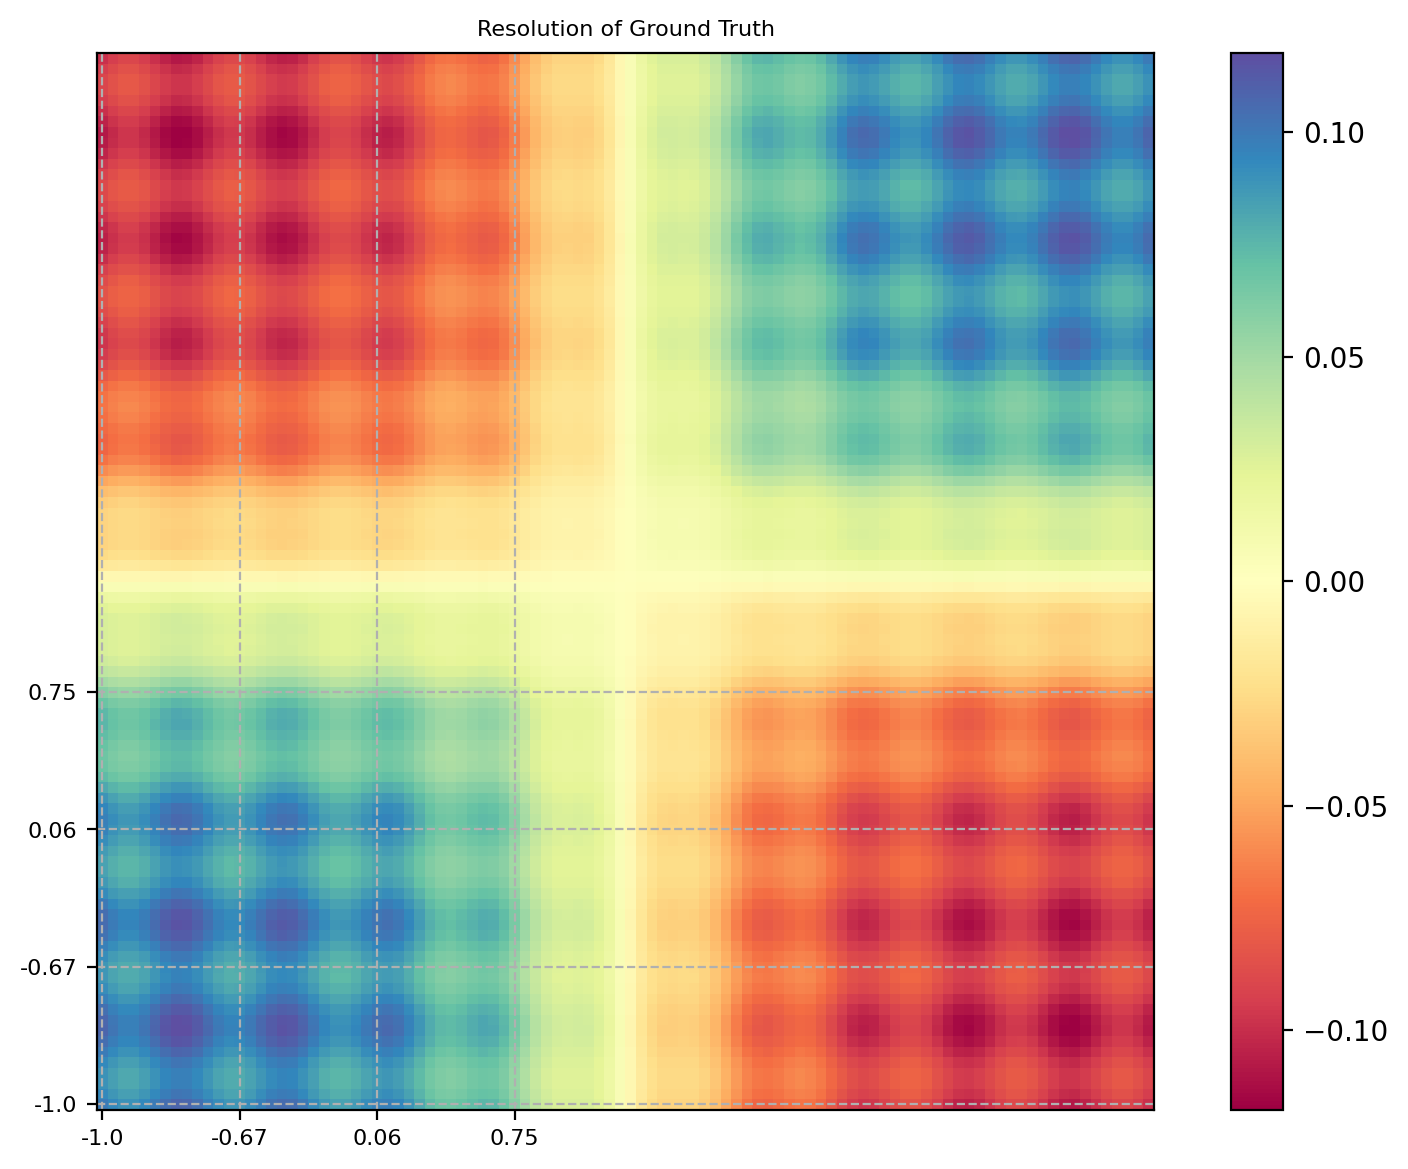

In [16]:
grid_plt = sob_2d.grid
xs_plt = sob_2d.axes
x_plt = grid_plt[:,0]
y_plt = grid_plt[:,1]
x_plt, y_plt = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
gt_plt = gt(x_plt, y_plt)#.reshape(len(xs_plt[1]),len(xs_plt[0]))
fn = None #"resolution_poisson_2d"
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
solver.plot2d(gt_plt, xs_plt[0], xs_plt[1], title="Resolution of Ground Truth", file_name=fn)

### Remark
You can either decide for the analytic solution or for the iterative solution.

### Gradient Flow :-: Analytic Solution AD-PSM

In [17]:
start = time.time()
KsK = 2*matmul(dmn.T, K.T, metric_2d(matmul(K, dmn)))\
        +2*matmul(bndr_0.T, metric_1d_0(bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(bndr_1))

Ksf = 2*matmul(dmn.T, K.T, metric_2d(-fXY))\
        +2*matmul(bndr_0.T, metric_1d_0(u_bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(u_bndr_1))

w = matmul(KsK.inverse(), Ksf)
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

/home/suarez08/PhD_PINNs/PSM_framework/utils.py:156: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  return torch.tensor([(w*_).detach().numpy() for _ in torch.split(x, len(w))]).reshape(len(x))


time consumption: 0.84s


## Errors AD-PSM

In [18]:
_, _ = solver.eval()
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

L1  Error: 8.798618930836029e-10
L2  Error: 1.1601874407368875e-09
Max Error: 1.25802650206841e-08


## Errors GF-PSM

ChebPoly(
  (fc): Linear(in_features=2601, out_features=1, bias=False)
)
pred rel. linf-error = 1.258027e-08
pred rel. l2-error = 8.798619e-10


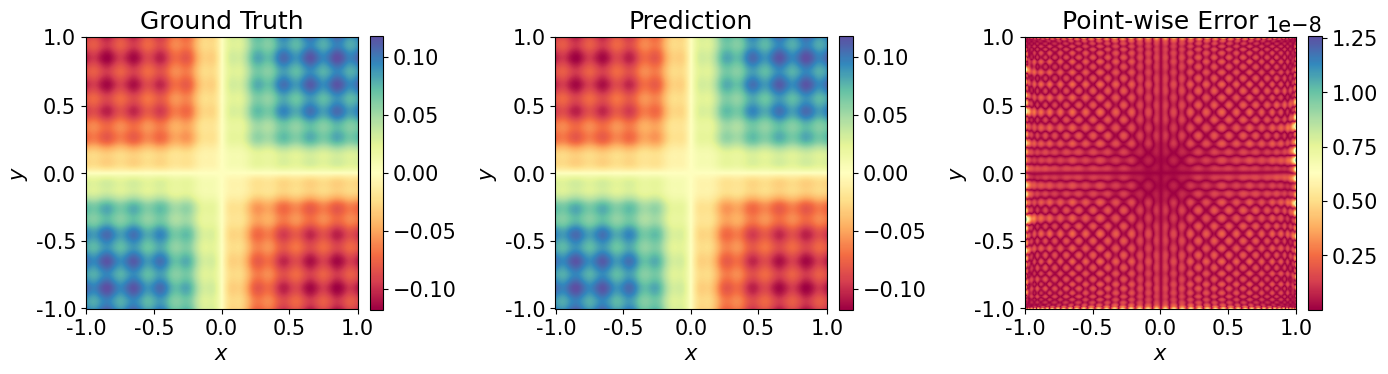

In [21]:
import matplotlib.pyplot as plt
Plot_sol.Plot(test_xs, gt, model, data)

### Gradient Flow :-: Iterative Solution GF-PSM

In [22]:
model.set_weights(torch.tensor([0.0]))
solver = Solver(
    dmns=[dmn, bndr_0, bndr_1],
    crits=[crit_dmn, crit_bndr_0, crit_bndr_1],
    model=model,
    test_axes=test_xs,
    grads=[grad_dmn, grad_bndr_0, grad_bndr_1],
    gt=gt,
    data=data)
optimizer = torch.optim.LBFGS(solver.model.parameters())
#optimizer = torch.optim.Adam(model.parameters())
solver.train(50, 10, optim=optimizer)
print('time consumption: %.2fs' % solver.get_time())

epoch 10: loss = 0.0049004948750960
epoch 20: loss = 0.0002205547806345
epoch 30: loss = 0.0000078242442072
epoch 40: loss = 0.0000004131923226
epoch 50: loss = 0.0000001166804044
time consumption: 12.59s


### Errors GF-PSM

In [23]:
_, _ = solver.eval()
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

L1  Error: 5.376259840455061e-05
L2  Error: 0.00010599286886274511
Max Error: 0.0029355856758205706


### Plots GF-PSM

ChebPoly(
  (fc): Linear(in_features=2601, out_features=1, bias=False)
)
pred rel. linf-error = 2.935586e-03
pred rel. l2-error = 5.376260e-05


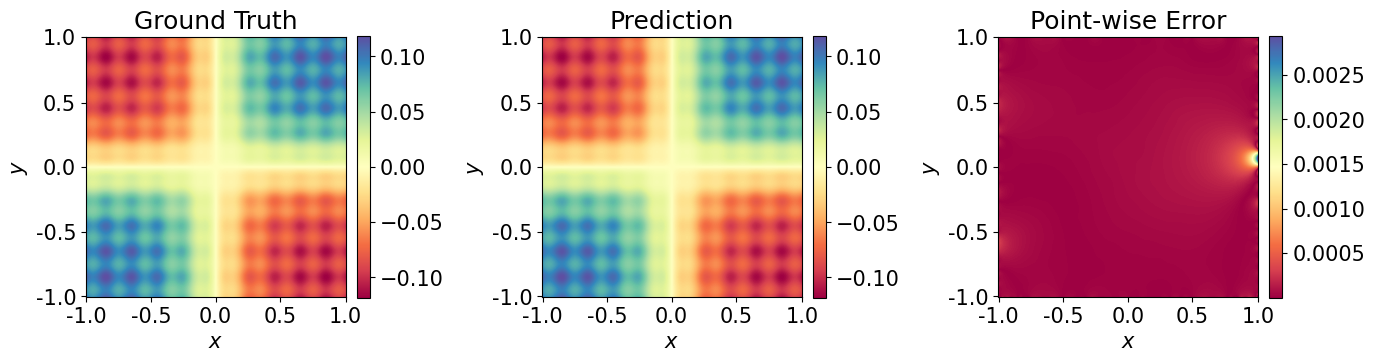

In [24]:
import matplotlib.pyplot as plt
folder = r'/home/suarez08/PhD_PINNs/Benchmark_Dominik/Results_Dominik/'
Plot_sol.Plot(test_xs, gt, model, data)